In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader 
from torchvision import datasets
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, ToTensor, Compose, Normalize

from typing import Optional

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Device

In [2]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True
print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11263MB, multi_processor_count=28)


## Dataset

In [3]:
# Normalize a tensor image with mean and standard deviation from ImageNet and add random corp/hflip
transform = Compose([ RandomCrop(32, padding=4), RandomHorizontalFlip(), ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)).to(device)])

# Download train data

training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
n_classes = len(test_data.classes)
print('Number of classes:', n_classes)

batch_size = 256

# Create data loaders.

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(len(train_dataloader))
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}", end='\n\n')
    break

Number of classes: 100
196
Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64



## ResNet blocks

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.downsample = downsample
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )

        self.relu = nn.ReLU()

    def forward(self, X):
        res = X
        output = self.layers(X)

        if self.downsample:
            res = self.downsample(X)
        output += res
        output = self.relu(output)
        return output
    


class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckResidualBlock, self).__init__()
        
        self.downsample = downsample

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels * 4)
        )

        self.relu = nn.ReLU()

    def forward(self, X):
        res = X
        output = self.layers(X)

        if self.downsample:
            res = self.downsample(X)

        output = self.relu(output + res)
        
        return output


## ResNet layer

In [6]:
class ResNetLayer(nn.Module):
    def __init__(self, block, n_blocks, in_channels, out_channels, stride, expansion=1):
        super(ResNetLayer, self).__init__()
        downsample = None

        if stride != 1 or out_channels * expansion != in_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * expansion)
            )

        layers = []

        layers.append(block(in_channels, out_channels, stride, downsample))

        for i in range(n_blocks-1):
            layers.append(block(out_channels * expansion, out_channels))

        self.layers = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.layers(X)


## ResNet

In [7]:
class ResNet(nn.Module):
    def __init__(self, architecture: Optional[int] = 18, layer: Optional[list[int]]=[2, 2, 2, 2], img_channels: int = 3, n_classes: int = 100):
        super(ResNet, self).__init__()

        self.architecture = architecture
        self.cifar = True

        expansion = 1

        block = ResidualBlock # Residual block that is used in ResNet layers

        ResNet_cifar = [20, 32, 44, 56, 110, 1202] # ResNet for CIFAR architectures

        

       

        if (architecture not in ResNet_cifar) or len(layer) != 3: # If achitecture does not correspond to ResNet for CIFAR => implement ResNet for ImageNet with image upsample
        
            self.cifar = False
            
            if architecture >= 50:      # Bottleneck residual blocks are used as part of deeper ResNets
                block = BottleneckResidualBlock
                expansion = 4

            self.upsample = nn.UpsamplingBilinear2d(scale_factor=7)

            self.conv1 = nn.Sequential(
                nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU()
            )

            # ResNet layers

            self.conv2 = nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                ResNetLayer(block, layer[0], 64, 64, 1, expansion)
            )

            self.conv3 = ResNetLayer(block, layer[1], 64 * expansion, 128, 2, expansion)

            self.conv4 = ResNetLayer(block, layer[2], 128 * expansion, 256, 2, expansion)

            self.conv5 = ResNetLayer(block, layer[3], 256 * expansion, 512, 2, expansion) 

            self.classicicator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * expansion, n_classes),
            # nn.Softmax()
            )
        else: # ResNet for CIFAR
            self.upsample = nn.Identity()

            self.conv1 = nn.Sequential(
                nn.Conv2d(img_channels, 16, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(16)
            )

             # ResNet layers

            self.conv2 = ResNetLayer(block, layer[0], 16, 16, 1)

            self.conv3 = ResNetLayer(block, layer[1], 16, 32, 1)

            self.conv4 = ResNetLayer(block, layer[2], 32, 64, 1)

            self.conv5 = nn.Identity()

            self.classicicator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, n_classes),
            # nn.Softmax()
            )

        self.avgpool = nn.AvgPool2d(7, stride=1)    
        

    def forward(self, X):
        X = self.upsample(X)
        X = self.conv1(X)  
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        X = self.conv5(X)

        if self.cifar:
            X = nn.functional.avg_pool2d(X, X.size()[3])
        else:
            X = self.avgpool(X)

        X = self.classicicator(X)
  
        return X

In [8]:
x =torch.rand(5, 3, 32, 32)
m = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
m1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
print(m(x).shape)
print(m1(m(x)).shape)

torch.Size([5, 64, 16, 16])
torch.Size([5, 64, 8, 8])


## For easier optimizer setup 

In [9]:
def setup_optimizer(to_optimize, optimizer = torch.optim.Adam, schedule = False, epochs = 10, lr = 0.01, weight_decay=1e-5):
    
    optimizer = optimizer(params = to_optimize.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None

    if schedule:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_dataloader))

    return optimizer, scheduler
    

## Function that gets current lr of optimizer

In [10]:
def curr_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

## Functions for training loop

In [11]:
def train(dataloader, model, loss_fn, optimizer, scheduler=None):
    model.train()
    train_loss = 0

    # To memorize losses and learning rates
    current_train_loss_history = []
    current_lr_history = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler:
            current_lr_history.append(scheduler.get_last_lr()) # save learning rate 
            scheduler.step()
        else:
            current_lr_history.append(curr_lr(optimizer))

        # print(f'Batch: {batch}')
         
        # if batch % 100 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader) # calculate mean loss for epoch
    current_train_loss_history.append(train_loss) # save current mean loss 

    print(f"Train: \n Avg loss: {train_loss:>8f}")

    return current_train_loss_history, current_lr_history




def test(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    current_test_loss_history = []
    current_test_metric_history = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    current_test_loss_history.append(test_loss)
    current_test_metric_history.append(correct * 100)
    
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    print("_______________________________")

    return current_test_loss_history, current_test_metric_history
      

In [12]:
def train_loop(model, epochs, optimizer, loss_fn, train_dataloader, test_dataloader, scheduler=None):

    train_loss_history = []
    lr_history = []
    test_loss_history = []
    test_metric_history = []

    for i in range(epochs):

        print(f'Epoch {i+1}\n')

        train_history = train(train_dataloader, model, loss_fn, optimizer, scheduler)
        test_history = test(test_dataloader, model, loss_fn, optimizer)

        train_loss_history = np.append(train_loss_history, train_history[0])
        lr_history = np.append(lr_history, train_history[1])
        test_loss_history = np.append(test_loss_history, test_history[0])
        test_metric_history = np.append(test_metric_history, test_history[1])

    print('Finished')

    return train_loss_history, lr_history, test_loss_history, test_metric_history

## Function to plot training results 

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.plot(history[2], label='test')
    ax1.plot(history[0], label='train')
    ax1.legend()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('loss vs epoch')
    ax1.grid()

    ax2.plot(history[3], label='test')
    ax2.legend()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.set_title('accuracy vs epoch')
    ax2.grid()

    ax3.plot(history[1])
    ax3.set_xlabel('batch')
    ax3.set_ylabel('lr')
    ax3.set_title('lr vs batch')
    ax3.grid()

# ResNet10

In [48]:
ResNet10 = ResNet(architecture=10, layer=[1, 1, 1, 1], n_classes=n_classes).to(device)
print(ResNet10)

ResNet(
  (upsample): UpsamplingBilinear2d(scale_factor=7.0, mode='bilinear')
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResNetLayer(
      (layers): Sequential(
        (0): ResidualBlock(
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): ReLU()
        )
      )
    )
  )
  (conv3): ResNetLayer(
    (layers): Sequential(


In [49]:
x = torch.randn(5, 3, 32, 32).to(device)
print(type(x))
y = ResNet10(x).to(device)
print(y.shape)

<class 'torch.Tensor'>
torch.Size([5, 100])


In [50]:
epoch = 20

loss_fn = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(ResNet10, schedule = True, epochs = epoch, lr = 0.01, weight_decay=1e-5)

In [51]:
ResNet10_history = train_loop(ResNet10, epoch, optimizer, loss_fn, train_dataloader, test_dataloader, scheduler)

Epoch 1

Train: 
 Avg loss: 3.790606
Test: 
 Accuracy: 14.8%, Avg loss: 3.648984
_______________________________
Epoch 2

Train: 
 Avg loss: 3.342003
Test: 
 Accuracy: 17.4%, Avg loss: 3.478765
_______________________________
Epoch 3

Train: 
 Avg loss: 2.913067
Test: 
 Accuracy: 24.4%, Avg loss: 3.091204
_______________________________
Epoch 4

Train: 
 Avg loss: 2.478280
Test: 
 Accuracy: 34.7%, Avg loss: 2.575702
_______________________________
Epoch 5

Train: 
 Avg loss: 2.137290
Test: 
 Accuracy: 41.4%, Avg loss: 2.241067
_______________________________
Epoch 6

Train: 
 Avg loss: 1.866633
Test: 
 Accuracy: 45.2%, Avg loss: 2.055201
_______________________________
Epoch 7

Train: 
 Avg loss: 1.643997
Test: 
 Accuracy: 45.7%, Avg loss: 2.087465
_______________________________
Epoch 8

Train: 
 Avg loss: 1.479906
Test: 
 Accuracy: 47.1%, Avg loss: 2.100828
_______________________________
Epoch 9

Train: 
 Avg loss: 1.345968
Test: 
 Accuracy: 53.8%, Avg loss: 1.755398
_______________

### Loss, accuracy, lr

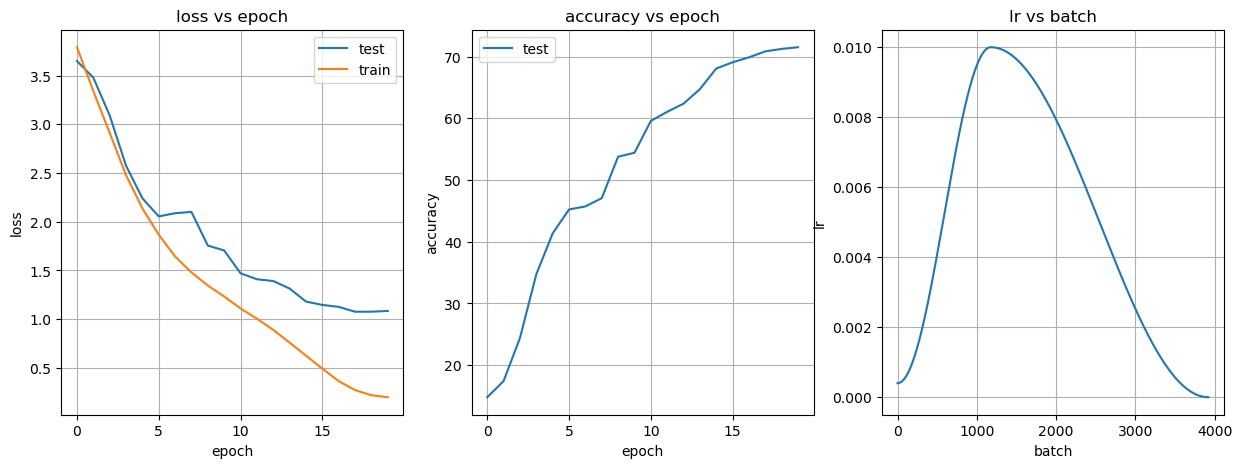

In [52]:
plot_history(ResNet10_history)

# ResNet18

In [53]:
ResNet18 = ResNet(architecture=20, layer=[2, 2, 2, 2], n_classes=n_classes).to(device)
print(ResNet18)

ResNet(
  (upsample): UpsamplingBilinear2d(scale_factor=7.0, mode='bilinear')
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResNetLayer(
      (layers): Sequential(
        (0): ResidualBlock(
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): ReLU()
        )
        (1): ResidualBlock(
          (layers): Sequential(
        

In [54]:
epoch = 25

loss_fn = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(ResNet18, schedule = True, epochs = epoch, lr = 0.01, weight_decay=1e-5)

In [55]:
ResNet18_history = train_loop(ResNet18, epoch, optimizer, loss_fn, train_dataloader, test_dataloader, scheduler)

Epoch 1

Train: 
 Avg loss: 3.793106
Test: 
 Accuracy: 13.3%, Avg loss: 3.677857
_______________________________
Epoch 2

Train: 
 Avg loss: 3.355842
Test: 
 Accuracy: 8.8%, Avg loss: 4.896815
_______________________________
Epoch 3

Train: 
 Avg loss: 2.881001
Test: 
 Accuracy: 20.2%, Avg loss: 3.659762
_______________________________
Epoch 4

Train: 
 Avg loss: 2.456166
Test: 
 Accuracy: 32.7%, Avg loss: 2.586005
_______________________________
Epoch 5

Train: 
 Avg loss: 2.114448
Test: 
 Accuracy: 37.2%, Avg loss: 2.416665
_______________________________
Epoch 6

Train: 
 Avg loss: 1.864928
Test: 
 Accuracy: 41.8%, Avg loss: 2.267185
_______________________________
Epoch 7

Train: 
 Avg loss: 1.667711
Test: 
 Accuracy: 43.8%, Avg loss: 2.171185
_______________________________
Epoch 8

Train: 
 Avg loss: 1.512867
Test: 
 Accuracy: 50.8%, Avg loss: 1.871328
_______________________________
Epoch 9

Train: 
 Avg loss: 1.371641
Test: 
 Accuracy: 50.4%, Avg loss: 1.865735
________________

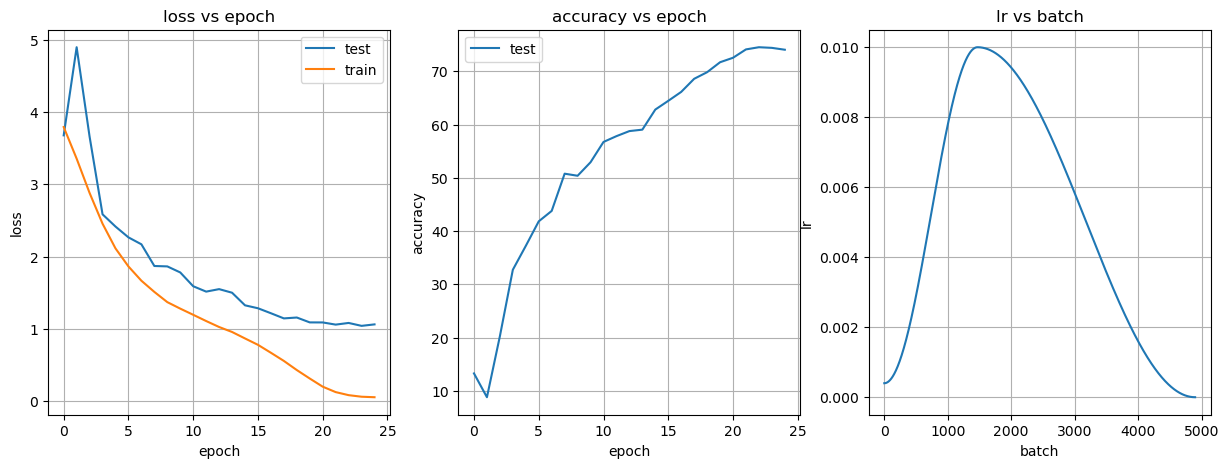

In [56]:
plot_history(ResNet18_history)

# ResNet32

In [72]:
ResNet32 = ResNet(architecture=32, layer=[5, 5, 5], n_classes=n_classes).to(device)
print(ResNet32)

ResNet(
  (upsample): Identity()
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ResNetLayer(
    (layers): Sequential(
      (0): ResidualBlock(
        (layers): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU()
      )
      (1): ResidualBlock(
        (layers): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2

In [73]:
with torch.no_grad():
    x = torch.randn(5, 3, 32, 32).to(device)
    print(type(x))
    y = ResNet32(x).to(device)
    print(y.shape)

<class 'torch.Tensor'>
torch.Size([5, 100])


In [74]:
epoch = 30

loss_fn = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(ResNet32, schedule = True, epochs = epoch, lr = 0.001, weight_decay=1e-4)

In [75]:
ResNet32_history = train_loop(ResNet32, epoch, optimizer, loss_fn, train_dataloader, test_dataloader, scheduler)

Epoch 1

Train: 
 Avg loss: 4.396999
Test: 
 Accuracy: 8.0%, Avg loss: 4.122257
_______________________________
Epoch 2

Train: 
 Avg loss: 3.923679
Test: 
 Accuracy: 11.9%, Avg loss: 3.796354
_______________________________
Epoch 3

Train: 
 Avg loss: 3.639802
Test: 
 Accuracy: 16.0%, Avg loss: 3.511820
_______________________________
Epoch 4

Train: 
 Avg loss: 3.361839
Test: 
 Accuracy: 17.3%, Avg loss: 3.352732
_______________________________
Epoch 5

Train: 
 Avg loss: 3.100795
Test: 
 Accuracy: 19.6%, Avg loss: 3.396950
_______________________________
Epoch 6

Train: 
 Avg loss: 2.886885
Test: 
 Accuracy: 20.5%, Avg loss: 3.346972
_______________________________
Epoch 7

Train: 
 Avg loss: 2.725111
Test: 
 Accuracy: 27.5%, Avg loss: 2.784015
_______________________________
Epoch 8

Train: 
 Avg loss: 2.571993
Test: 
 Accuracy: 29.2%, Avg loss: 2.834394
_______________________________
Epoch 9

Train: 
 Avg loss: 2.438484
Test: 
 Accuracy: 30.2%, Avg loss: 2.800802
________________

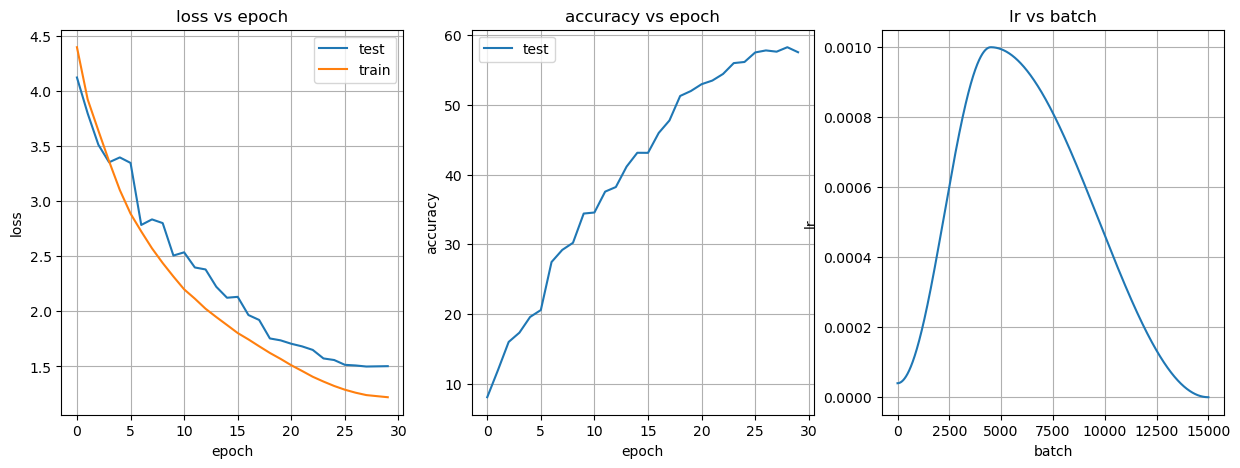

In [76]:
plot_history(ResNet32_history)

# ResNet50

In [14]:
ResNet50 = ResNet(architecture=50, layer=[3, 4, 6, 3], n_classes=n_classes).to(device)
print(ResNet50)

ResNet(
  (upsample): UpsamplingBilinear2d(scale_factor=7.0, mode='bilinear')
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResNetLayer(
      (layers): Sequential(
        (0): BottleneckResidualBlock(
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (layers): Sequential(
            (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [15]:
with torch.no_grad():
    x = torch.randn(5, 3, 32, 32).to(device)
    print(type(x))
    y = ResNet50(x).to(device)
    print(y.shape)

<class 'torch.Tensor'>
torch.Size([5, 100])


In [16]:
batch_size = 100

# Create data loaders.

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [17]:
epoch = 15

loss_fn = nn.CrossEntropyLoss()
optimizer, scheduler = setup_optimizer(ResNet50, schedule = True, epochs = epoch, lr = 0.01)

In [18]:
ResNet50_history = train_loop(ResNet50, epoch, optimizer, loss_fn, train_dataloader, test_dataloader, scheduler)

Epoch 1

Train: 
 Avg loss: 4.076531
Test: 
 Accuracy: 9.5%, Avg loss: 4.941340
_______________________________
Epoch 2

Train: 
 Avg loss: 3.677944
Test: 
 Accuracy: 16.1%, Avg loss: 4.866861
_______________________________
Epoch 3

Train: 
 Avg loss: 3.265081
Test: 
 Accuracy: 21.7%, Avg loss: 3.215420
_______________________________
Epoch 4

Train: 
 Avg loss: 2.800746
Test: 
 Accuracy: 26.8%, Avg loss: 3.039975
_______________________________
Epoch 5

Train: 
 Avg loss: 2.389600
Test: 
 Accuracy: 35.7%, Avg loss: 2.502385
_______________________________
Epoch 6

Train: 
 Avg loss: 2.141617
Test: 
 Accuracy: 41.4%, Avg loss: 2.239494
_______________________________
Epoch 7

Train: 
 Avg loss: 1.954750
Test: 
 Accuracy: 43.7%, Avg loss: 2.142801
_______________________________
Epoch 8

Train: 
 Avg loss: 1.791815
Test: 
 Accuracy: 47.4%, Avg loss: 1.981185
_______________________________
Epoch 9

Train: 
 Avg loss: 1.620303
Test: 
 Accuracy: 52.5%, Avg loss: 1.751349
________________

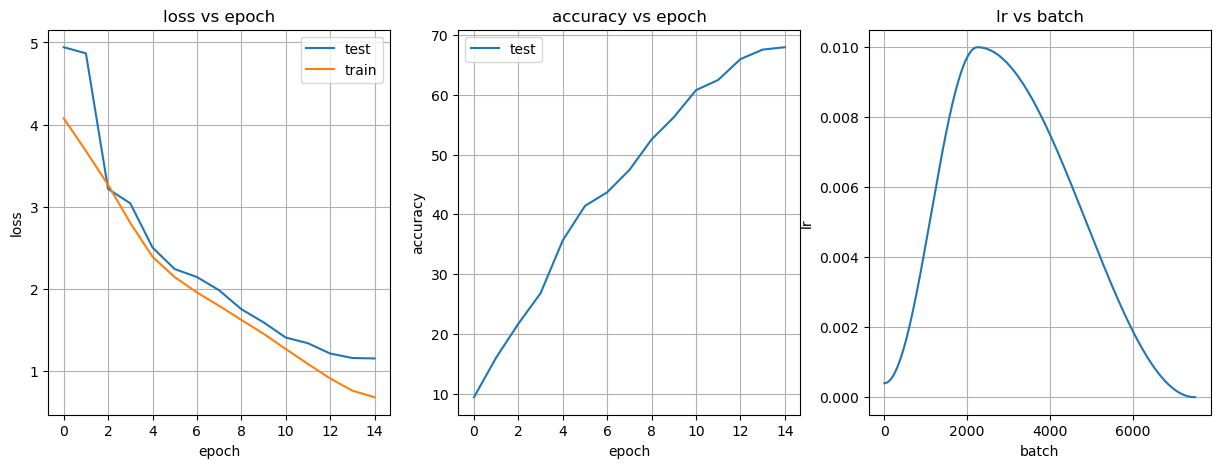

In [19]:
plot_history(ResNet50_history)